# Using QSVT for matrix inversion

In this notebook, we will use the Quantum Singular Value Transformation (QSVT) algorithm to solve the problem of matrix inversion.
The demo is based on the paper [Grand unification of quantum algorithms](#grand).

## Problem Encoding

We start by defining a specific problem. We can take matrix that is not symmetric, in comparison to the HHL algorithm.

We will encode $A$ in a larger Unitary matrix. For simplicity, we will just sample a random unitary U_a, and take it's first block as $A$

In [1]:
import numpy as np
import scipy

# the size of the unitary which block encodes A
REG_SIZE = 3


def get_random_unitary(num_qubits, seed=4):
    np.random.seed(seed)
    X = np.random.rand(2**num_qubits, 2**num_qubits)
    U, s, V = np.linalg.svd(X)
    return U @ V.T


U_a = get_random_unitary(REG_SIZE)

A_dim = int(U_a.shape[0] / 2)
A = U_a[:A_dim, :A_dim]
print(A)

[[-0.05338002 -0.36103662 -0.54016489 -0.39026125]
 [-0.33304121  0.10648228  0.37346704 -0.33977916]
 [ 0.4167817  -0.75180519  0.17593867  0.20944773]
 [ 0.26891079 -0.05333795 -0.32668787 -0.33602829]]


Make sure A's singular values are smaller than 1:

In [2]:
assert not (np.linalg.svd(A)[1] > 1).sum()

In [3]:
b = np.arange(A_dim)
b = b / np.linalg.norm(b)
print(b)

[0.         0.26726124 0.53452248 0.80178373]


Verify $U_{a}$ is indeed unitary

In [4]:
assert np.allclose(U_a @ U_a.T, np.eye(U_a.shape[0]), rtol=1e-5, atol=1e-6)

Calculate the condition number $\kappa=max(\frac{1}{\sigma_i})$

In [5]:
kappa = max(1 / np.linalg.svd(A)[1])
print(kappa)

3.4598628384708716


In [6]:
np.linalg.svd(A)[1]

array([0.99132079, 0.84978294, 0.52403662, 0.2890288 ])

## Now to the quantum part!

### Defining the QSVT circuit for the problem

We start with the general qsvt framework definition. It accepts a unitary which block-encode a matrix together with projector-controlled-cnot functions which identify the block in which the matrix is encoded.

It applies the `qsvt_step` multiple times, iterating over the rotation angles provided which encode the polynomial transformation.
Notice - The last step is quite tricky and depend on the specific transformation we wish to perform. Here the code is suitable for the matrix-inversion case. Also - we wrap the auxilliary qubit with $H$ gates.

In [7]:
from typing import List, Literal

from classiq.qmod import (
    CX,
    IDENTITY,
    RZ,
    H,
    Output,
    QArray,
    QBit,
    QCallable,
    QFunc,
    QParam,
    X,
    allocate,
    if_,
    invert,
    join,
    prepare_amplitudes,
    repeat,
    split,
    unitary,
)


@QFunc
def projector_controlled_phase(
    phase: QParam[float],
    proj_cnot: QCallable[QArray[QBit, REG_SIZE], QBit],
    qbv_reg: QArray[QBit, REG_SIZE],
    qbv_aux: QBit,
) -> None:
    proj_cnot(qbv_reg, qbv_aux)
    RZ(phase, qbv_aux)
    proj_cnot(qbv_reg, qbv_aux)


@QFunc
def qsvt_step(
    phase_seq: QParam[List[float]],
    num_qubits: QParam[int],
    index: QParam[int],
    proj_cnot_1: QCallable[QArray[QBit, "num_qubits"], QBit],
    proj_cnot_2: QCallable[QArray[QBit, "num_qubits"], QBit],
    u: QCallable[QArray[QBit, "num_qubits"]],
    qbv: QArray[QBit, "num_qubits+1"],
):
    qbv_reg = QArray("qbv_reg")
    qbv_aux = QArray("qbv_aux")

    split(num_qubits, 1, in_=qbv, out1=qbv_reg, out2=qbv_aux)

    projector_controlled_phase(phase_seq[2 * index], proj_cnot_1, qbv_reg, qbv_aux)
    u(qbv_reg)
    projector_controlled_phase(
        phase_seq[2 * index + 1],
        proj_cnot_2,
        qbv_reg,
        qbv_aux,
    )

    if_(
        condition="2 * index +  2 == len(phase_seq)",
        then=lambda: IDENTITY(qbv_reg),
        else_=lambda: invert(lambda: u(qbv_reg)),
    )

    join(qbv_reg, qbv_aux, qbv)


@QFunc
def qsvt(
    num_qubits: QParam[int],
    phase_seq: QParam[List[float]],
    proj_cnot_1: QCallable[QArray[QBit, "num_qubits"], QBit],
    proj_cnot_2: QCallable[QArray[QBit, "num_qubits"], QBit],
    u: QCallable[QArray[QBit, "num_qubits"]],
    qbv_reg: QArray[QBit, "num_qubits"],
    qbv_aux: QBit,
) -> None:
    H(qbv_aux)

    qbv = QArray("qbv")
    join(qbv_reg, qbv_aux, qbv)
    repeat(
        count="len(phase_seq) // 2",
        iteration=lambda index: qsvt_step(
            phase_seq, num_qubits, index, proj_cnot_1, proj_cnot_2, u, qbv
        ),
    )

    split(num_qubits, 1, in_=qbv, out1=qbv_reg, out2=qbv_aux)
    H(qbv_aux)

### Matrix inversion logic

Here define the specific use case of the matrix inversion. In this case, both projectors are the same, and expect the block encoded matrix to apply on the states where the first qubit value is $|0\rangle$, hence:

In [8]:
@QFunc
def qsvt_inversion(
    num_qubits: QParam[int],
    phase_seq: QParam[List[float]],
    u: QCallable[QArray[QBit, "num_qubits"]],
    qbv_reg: QArray[QBit, "num_qubits"],
    qbv_aux: Output[QBit],
) -> None:
    allocate(1, qbv_aux)

    def projector_cnot(qbv_state: QArray[QBit, "num_qubits"], qbv_aux: QBit):
        X(qbv_state[num_qubits - 1])
        CX(qbv_state[num_qubits - 1], qbv_aux)
        X(qbv_state[num_qubits - 1])

    qsvt(
        num_qubits,
        phase_seq,
        lambda arg0, arg1: projector_cnot(arg0, arg1),
        lambda arg0, arg1: projector_cnot(arg0, arg1),
        u,
        qbv_reg,
        qbv_aux,
    )

### Get the phase sequence for the inverse function

Get directly the coef of the sign function, based on the erfc approximation, using the `pyqsp` package:

In [9]:
import pyqsp

pg = pyqsp.poly.PolyOneOverX()
pcoefs = pg.generate(epsilon=0.05, kappa=kappa)

b=50, j0=20
[PolyOneOverX] minimum [-4.54115308] is at [-0.15883407]: normalizing
[PolyOneOverX] bounding to 0.5
[pyqsp.PolyOneOverX] pcoefs=[ 0.00000000e+00  5.50501781e+00  0.00000000e+00 -1.34815163e+02
  0.00000000e+00  2.15191868e+03  0.00000000e+00 -2.50709632e+04
  0.00000000e+00  2.25502975e+05  0.00000000e+00 -1.61156021e+06
  0.00000000e+00  9.27860774e+06  0.00000000e+00 -4.33007019e+07
  0.00000000e+00  1.64161062e+08  0.00000000e+00 -5.05820849e+08
  0.00000000e+00  1.26571548e+09  0.00000000e+00 -2.56671992e+09
  0.00000000e+00  4.20178645e+09  0.00000000e+00 -5.51711201e+09
  0.00000000e+00  5.75258027e+09  0.00000000e+00 -4.69115938e+09
  0.00000000e+00  2.92363543e+09  0.00000000e+00 -1.34306985e+09
  0.00000000e+00  4.28212620e+08  0.00000000e+00 -8.45647522e+07
  0.00000000e+00  7.78663704e+06]


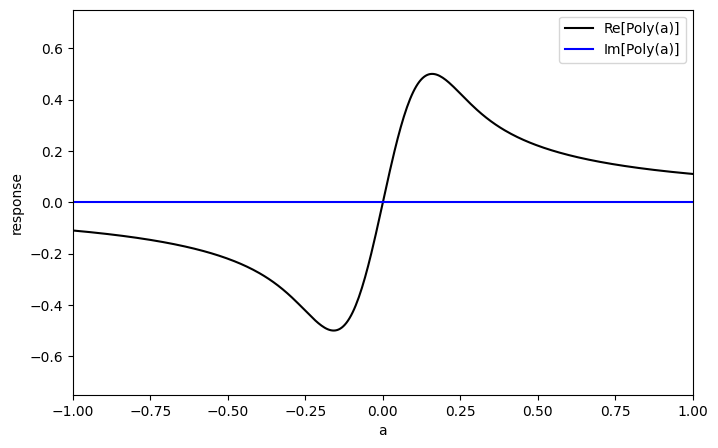

In [10]:
import numpy as np
from pyqsp.angle_sequence import Polynomial, QuantumSignalProcessingPhases

poly = Polynomial(pcoefs)

# choosing 'z' this basis since P(1)=1 and won't to avoid the QSP basis change. Anyway, we are not measuring directly this qubit.
ang_seq = QuantumSignalProcessingPhases(
    poly, signal_operator="Wx", method="laurent", measurement="x"
)
pyqsp.response.PlotQSPResponse(ang_seq, signal_operator="Wx", measurement="x")

#### Adjusting phase conventions

There conventions by which the `pyqsp` package calculates the the phases are different from the phases we need for this qsvt circuit. The following block takes care for them.

As $R(a)=-i*e^{i\frac{\pi}{4}Z}W(a)e^{i\frac{\pi}{4}Z}$ and we have odd number of rotations, we get an i phase to our polynomial, so we get $Im(P(a))$ instead of the real part. So we will get the result in the $|1\rangle$ state in the ancilla. However, we can fix it by adding $\pi/2$ phase to the last or first rotation.

In [11]:
# change the R(x) to W(x), as the phases are in the W(x) conventions
phases = np.array(ang_seq)
phases = phases - np.pi / 2
phases[0] = phases[0] + np.pi / 4
phases[-1] = phases[-1] + np.pi / 4 + np.pi / 2

# verify conventions. minus is due to exp(-i*phi*z) in qsvt in comparison to qsp
phases = -2 * phases

### Using the inversion function to solve linear system - `main` function

The following block defines the `main` function. This is the entry point for the quantum algorithm, which brings all previous parts together.

Specifically, we will use the function `prepare_amplitudes` for loading the vector $b$ into the quantum state.

Then apply the 'qsvt_inversion`. We use the to the dagger of the unitary $U$ which block encodes $A$, because, using the SVD decomposition:
$$
\begin{align}
A &=W\Sigma V^\dagger\\
A^\dagger &=V^\dagger \Sigma W\\
A^{-1} &= V^\dagger \Sigma^{-1}W\\
\end{align}
$$

In [12]:
@QFunc
def main(
    qbv_state: Output[QArray[QBit, REG_SIZE - 1]],
    qbv_block: Output[QBit],
    qbv_aux: Output[QBit],
) -> None:
    qbv_reg = QArray("qbv_reg")

    prepare_amplitudes(b.tolist(), 0, qbv_state)

    allocate(1, qbv_block)
    join(qbv_state, qbv_block, qbv_reg)

    qsvt_inversion(
        num_qubits=REG_SIZE,
        phase_seq=list(phases),
        u=lambda arg0: unitary(
            # Here we can just use the transpose of A as is it real valued
            elements=U_a.T.tolist(),
            target=arg0,
        ),
        qbv_reg=qbv_reg,
        qbv_aux=qbv_aux,
    )

    split(REG_SIZE - 1, 1, in_=qbv_reg, out1=qbv_state, out2=qbv_block)

## Synthesizing and Executing the circuit using state-vector simulator, to get $x=A^{-1}b$

In [13]:
from classiq import create_model, execute, set_execution_preferences, show, synthesize
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

# convert the functions to a qmod model
qmod = create_model(main)

# we will want to execute this qmod on a state-vector simulator:
execution_preferences = ExecutionPreferences(
    num_shots=1,
    backend_preferences=ClassiqBackendPreferences(
        backend_name="aer_simulator_statevector"
    ),
)
qmod = set_execution_preferences(qmod, execution_preferences)

with open("qsvt_matrix_inversion.qmod", "w") as f:
    f.write(qmod)

synthesize the model to a quantum program:

In [14]:
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/6b43d111-510c-4022-8740-b672ff01a1b8?version=0.34.0.dev0%2B124706fb0e


Execute on the simulator

In [15]:
raw_results = execute(qprog).result()

## Post processing

We will be interested in the projection of the state vector on the states where both the auxilliary qubit and the block qubit are $|0\rangle$.

In [16]:
def parse_results(res):
    parsed_state_vector = res[0].value.parsed_state_vector

    d = {
        parsed_state["qbv_state"]: parsed_state.amplitude
        for parsed_state in parsed_state_vector
        if parsed_state["qbv_aux"] == parsed_state["qbv_block"] == 0.0
    }

    values = np.array([d[i] for i in range(len(d))])
    global_phase = np.angle(values)[0]
    values = np.real(values / np.exp(1j * global_phase))
    normalization = np.linalg.norm(
        [
            parsed_state.amplitude
            for parsed_state in parsed_state_vector
            if parsed_state["qbv_block"] == 0.0
        ]
    )
    computed_x = values / normalization
    return computed_x

In [17]:
computed_x = parse_results(raw_results)
print(computed_x)

[ 0.3089865   0.02161539  0.14214859 -0.26100822]


Now compare to the expected solution:

In [18]:
expected_x = 1 / (2 * kappa) * (np.linalg.inv(A) @ b)
print(expected_x)

assert np.allclose(computed_x, expected_x, rtol=0.1)

[ 0.29134204  0.02176207  0.13386997 -0.24527315]


## References

<a id='grand'>[1]</a>: [Martyn JM, Rossi ZM, Tan AK, Chuang IL. Grand unification of quantum algorithms. PRX Quantum. 2021 Dec 3;2(4):040203.](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.040203)
